In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import classification_report

In [2]:
data_df = pd.read_csv("data/cpp_df.csv")
partial_df = data_df.sample(frac = 0.001, random_state = 1).reset_index(drop=True)
X = partial_df.drop(["Antigen", "Kmerized_sequences"],axis=1)
y = partial_df.pop("Antigen")

In [3]:
#Train test split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123, stratify = y)

#Print sizes of the split data
print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"y_train : {y_train.shape}")
print(f"y_test : {y_test.shape}")

X_train : (11, 21)
X_test : (3, 21)
y_train : (11,)
y_test : (3,)


In [4]:
#Check stratification ratios
y_train_strat = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
y_test_strat = len(y_test[y_test == 0]) / len(y_test[y_test == 1])
print(f"y_train : {y_train.value_counts()}")
print('Ratio of 0:1 in y_train: %0.2f' % y_train_strat )
print(f"y_test : {y_test.value_counts()}")
print('Ratio of 0:1 in y_test: %0.2f' % y_test_strat) 

y_train : 0    8
1    3
Name: Antigen, dtype: int64
Ratio of 0:1 in y_train: 2.67
y_test : 0    2
1    1
Name: Antigen, dtype: int64
Ratio of 0:1 in y_test: 2.00


In [5]:
def summarize_results(grid_result, model_name):
    # summarize results
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%0.2f (%0.2f) with: %r" % (mean, stdev, param))
        
    # Best estimator object
    print("---------------------------------------------------")
    print(f"Best Model = {grid_result.best_estimator_}")
    print(f"Best Model parameters = {grid_result.best_params_}")

    #Score on the test set
    print("---------------------------------------------------")
    print("Accuracy score on the test set = %0.2f" % grid_result.score(X_test, y_test))
    print("---------------------------------------------------")
    
    #Summarizing and storing the grid search in a dataframe
    grid_search_results = pd.DataFrame(grid_result.cv_results_)
    grid_search_results = grid_search_results.sort_values(by = 'mean_test_score', ascending = False )
        
    #Output the info to a text file
    filename = "model outputs/"+model_name+"_grid_search_results.txt"
    f = open(filename, 'w')
    print(f"Best performing model = {grid_result.best_estimator_} \n", file = f)
    print("Accuracy score on the test set = %0.2f \n" % grid_result.score(X_test, y_test) , file = f)
    print(f"Model parameters = {grid_result.best_params_} \n", file = f)
    print(grid_search_results, file = f)
    f.close()

In [6]:
def get_ROC_curve(grid_result, model_name, model):

    #calculate and plot receiver operating characteristics (ROC) and calculate area under the curve (AUC)
    if isinstance(model, RidgeClassifier): 
        dec_probs = grid_result.decision_function(X_test)
        y_proba = np.exp(dec_probs) / np.sum(np.exp(dec_probs))

    else:
        y_proba = grid_result.predict_proba(X_test)[:,1]
    
    
    fprs, tprs, thresholds = roc_curve(y_test, y_proba)  
    roc_auc = roc_auc_score(y_test, y_proba)    
    print(f'Area under curve (AUC) for {model_name} = %0.2f' % roc_auc)
    
    fig = plt.figure()
    plt.plot(fprs, tprs, color='darkorange',
             lw=2, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="best")

    #save ROC curve to file
    plt.savefig(f"model outputs/{model_name}_ROC_AUC_curve.pdf")
    plt.show()

   

In [7]:
def get_confusion_matrix(grid_result, model_name):
        
    # Generate the confusion matrix

    # get best model from grid search
    best_model = grid_result.best_estimator_

    #fit best model on training data
    best_model_result = best_model.fit(X_train, y_train)

    #predict y_values by using the .predict method
    y_pred = best_model_result.predict(X_test)

    #generate confusion matrix
    my_confusion_matrix = confusion_matrix(y_test, y_pred)

            
    #Get classification report
    print(f"Classification report for {str(model_name)} \n")
    report_initial = classification_report(y_test, y_pred)
    print(report_initial)

    #save classification report to file
    filename = "model outputs/"+str(model_name)+"_classification_report.txt"
    f = open(filename, 'w')
    print(f"Classification report for {str(model_name)} \n", file=f)
    print(report_initial, file = f)
    f.close()
    
    # Saving the confusion matrix to file  

    #plot confusion matrix
    sns.heatmap(my_confusion_matrix, annot=True, fmt = '.0f') 
    plt.xlabel("Predicted classes")
    plt.ylabel("Actual classes")
    plt.title(f'confusion matrix for {model_name}')

    #save confusion matrix to file
    plt.savefig(f"model outputs/{model_name}_confusion_matrix.pdf")
    plt.show()


In [8]:
def run_classifiers(model):
    
   #For use in various print statements later
    model_name = str(model).replace("()", "")
   
    #CREATE LISTS OF HYPER_PARAMETERS TO TUNE
    if isinstance(model, LogisticRegression):
        
        #Max_iter
        max_iter = [10000]
        
        #Create list of solvers
        solvers = ['newton-cg', 'lbfgs', 'liblinear']

        #Create list of penalty values
        penalty = ['l1', 'l2']

        #Create list of c_values
        c_values = [100, 10, 1.0, 0.1, 0.01]

        #Convert the lists to a dictionary called grid
        grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter=max_iter)
    
    if isinstance(model, RidgeClassifier):
        #Create list of alpha values
        alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

        #Convert the lists to a dictionary called grid
        grid = dict(alpha=alpha)

    if isinstance(model, SVC):

        #Create list of kernels
        kernel = ['poly', 'rbf', 'sigmoid']

        #Create list of c_values
        C = [50, 10, 1.0, 0.1, 0.01]

        #Create list of gammas
        gamma = ['scale']
        
        #Probability
        probability = [True]

        #Convert the lists to a dictionary called grid
        grid = dict(kernel=kernel,C=C,gamma=gamma, probability=probability)
       
    if isinstance(model, RandomForestClassifier):
        
        #Create list of n_estimators
        n_estimators = [10, 100, 1000]

        #Create list of max_features
        max_features = ['sqrt', 'log2']

        #Convert the lists to a dictionary called grid
        grid = dict(n_estimators=n_estimators,max_features=max_features)
        
    if isinstance(model, GradientBoostingClassifier):
        
        #Create list of n_estimators
        n_estimators = [5, 15, 25, 35, 45]

        #Create list of learning rates
        learning_rate = [0.001, 0.01, 0.1]

        #Create list of max_depths
        max_depth = [3, 7, 9]

        #Convert the lists to a dictionary called grid
        grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
        
        
    if isinstance(model, MLPClassifier):  
        
        #Create list of solvers
        solvers = ['lbfgs', 'sgd', 'adam']

        #Create list of solvers
        max_iter = [100, 250, 500, 750, 1000, 1250, 1500]

        #Create list of alphas
        alpha = [0.1   , 0.01  , 0.001 , 0.0001]

        #Create list of hidden_layer_sizes
        hidden_layer_sizes = [10 , 20]

        #Convert the lists to a dictionary called grid
        grid = dict(solver=solvers,alpha=alpha,max_iter=max_iter, hidden_layer_sizes=hidden_layer_sizes)
        
    if isinstance(model, KNeighborsClassifier): 
        #Create list of n_neighbors
        n_neighbors = range(1, 21, 2)

        #Create list of weights
        weights = ['uniform', 'distance']

        #Create list of metrics
        metric = ['euclidean', 'manhattan', 'minkowski']

        #Convert the lists to a dictionary called grid
        grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
        
    if isinstance(model, DecisionTreeClassifier):

        #Create list of depths
        max_depth = range(1, 21, 2)

        #Create list of max_features
        max_features = ['auto', 'sqrt', 'log2', 'none']

        #Create list of min_samples_leaf
        min_samples_leaf = [1, 2, 3]

        #Create list of splitters
        splitter = ['best', 'random']

        #Create list of criterion
        criterion = ['gini', 'entropy']

        #Convert the lists to a dictionary called grid
        grid = dict(max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, splitter=splitter, criterion=criterion)
    
    else:
        print(f"Model name {model} not found")

    #Define the grid search
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, verbose=1)

    #Fit the grid search
    grid_result = grid_search.fit(X_train, y_train)

    summarize_results(grid_result, model_name)
    get_ROC_curve(grid_result, model_name, model)
    get_confusion_matrix(grid_result, model_name)

Model name LogisticRegression() not found
Fitting 5 folds for each of 30 candidates, totalling 150 fits
nan (nan) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'newton-cg'}
nan (nan) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'lbfgs'}
0.73 (0.23) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
0.83 (0.21) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.83 (0.21) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.83 (0.21) with: {'C': 100, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
nan (nan) with: {'C': 10, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'newton-cg'}
nan (nan) with: {'C': 10, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'lbfgs'}
0.73 (0.23) with: {'C': 10, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}
0.73 (0.23) with: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.73 (0.23) with: {'C': 10, 'max_iter': 

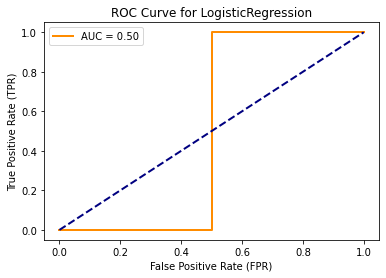

Classification report for LogisticRegression 

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3



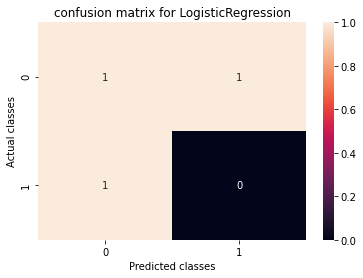

Model name RidgeClassifier() not found
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.83 (0.21) with: {'alpha': 0.1}
0.73 (0.23) with: {'alpha': 0.2}
0.73 (0.23) with: {'alpha': 0.3}
0.73 (0.23) with: {'alpha': 0.4}
0.73 (0.23) with: {'alpha': 0.5}
0.73 (0.23) with: {'alpha': 0.6}
0.73 (0.23) with: {'alpha': 0.7}
0.73 (0.23) with: {'alpha': 0.8}
0.73 (0.23) with: {'alpha': 0.9}
0.73 (0.23) with: {'alpha': 1.0}
---------------------------------------------------
Best Model = RidgeClassifier(alpha=0.1)
Best Model parameters = {'alpha': 0.1}
---------------------------------------------------
Accuracy score on the test set = 0.67
---------------------------------------------------
Area under curve (AUC) for RidgeClassifier = 0.50


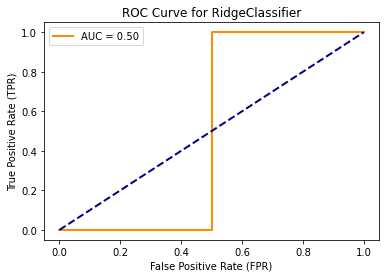

Classification report for RidgeClassifier 

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



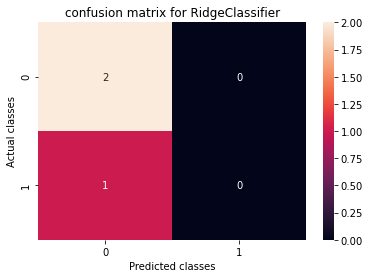

Model name SVC() not found
Fitting 5 folds for each of 15 candidates, totalling 75 fits
0.73 (0.23) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}
0.73 (0.23) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
0.57 (0.39) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid', 'probability': True}
0.73 (0.23) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}
0.73 (0.23) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
0.57 (0.39) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid', 'probability': True}
0.73 (0.23) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}
0.73 (0.23) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
0.73 (0.23) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid', 'probability': True}
0.73 (0.23) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}
0.73 (0.23) with: {'C': 0.1, 'gamma': 'scale', 'kern

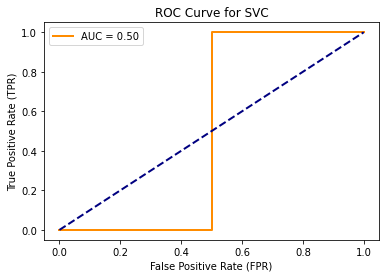

Classification report for SVC 

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



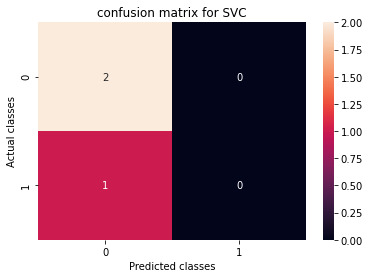

Model name RandomForestClassifier() not found
Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.63 (0.19) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.73 (0.23) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.73 (0.23) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.73 (0.23) with: {'max_features': 'log2', 'n_estimators': 10}
0.73 (0.23) with: {'max_features': 'log2', 'n_estimators': 100}
0.73 (0.23) with: {'max_features': 'log2', 'n_estimators': 1000}
---------------------------------------------------
Best Model = RandomForestClassifier(max_features='sqrt')
Best Model parameters = {'max_features': 'sqrt', 'n_estimators': 100}
---------------------------------------------------
Accuracy score on the test set = 0.67
---------------------------------------------------
Area under curve (AUC) for RandomForestClassifier = 0.50


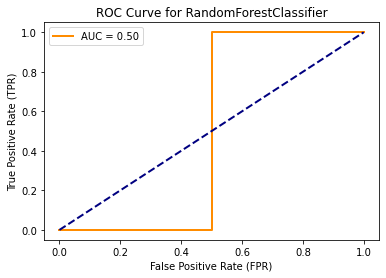

Classification report for RandomForestClassifier 

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



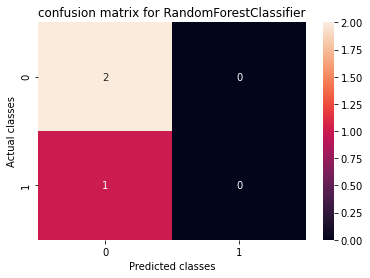

Model name GradientBoostingClassifier() not found
Fitting 5 folds for each of 45 candidates, totalling 225 fits
0.73 (0.23) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 5}
0.73 (0.23) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 15}
0.73 (0.23) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 25}
0.73 (0.23) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 35}
0.73 (0.23) with: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 45}
0.73 (0.23) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 5}
0.73 (0.23) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 15}
0.73 (0.23) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 25}
0.73 (0.23) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 35}
0.73 (0.23) with: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 45}
0.73 (0.23) with: {'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 5}
0.73 (0.23) with: {'le

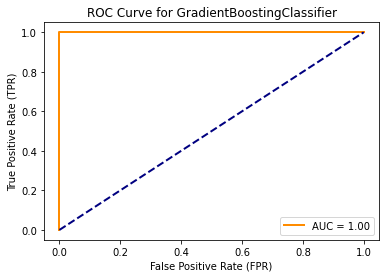

Classification report for GradientBoostingClassifier 

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



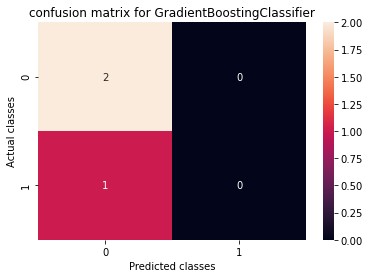

Model name MLPClassifier() not found
Fitting 5 folds for each of 168 candidates, totalling 840 fits
0.83 (0.21) with: {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 100, 'solver': 'lbfgs'}
0.67 (0.28) with: {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 100, 'solver': 'sgd'}
0.73 (0.23) with: {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 100, 'solver': 'adam'}
0.83 (0.21) with: {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 250, 'solver': 'lbfgs'}
0.73 (0.23) with: {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 250, 'solver': 'sgd'}
0.73 (0.23) with: {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 250, 'solver': 'adam'}
0.83 (0.21) with: {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 500, 'solver': 'lbfgs'}
0.73 (0.23) with: {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 500, 'solver': 'sgd'}
0.73 (0.23) with: {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 500, 'solver': 'adam'}
0.83 (0.21) with: {'alpha': 0.1, 'hidden_layer_sizes':

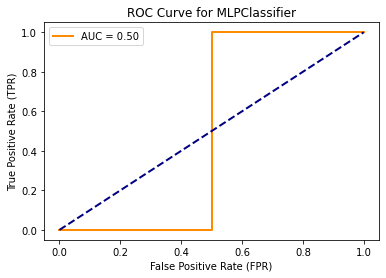

Classification report for MLPClassifier 

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



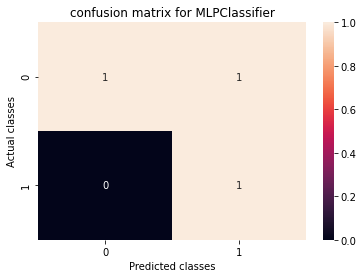

Model name KNeighborsClassifier() not found
Fitting 5 folds for each of 60 candidates, totalling 300 fits
0.57 (0.23) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.57 (0.23) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.83 (0.21) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.83 (0.21) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.73 (0.23) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.73 (0.23) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.73 (0.23) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.73 (0.23) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
nan (nan) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
nan (nan) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
nan (nan) with: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'un

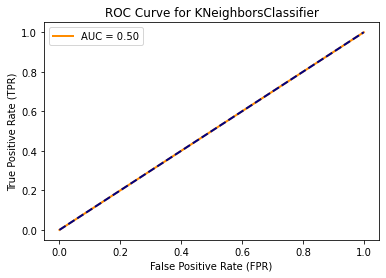

Classification report for KNeighborsClassifier 

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



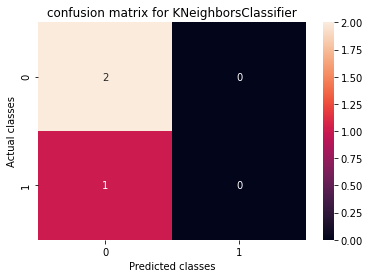

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
0.83 (0.21) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'splitter': 'best'}
0.83 (0.21) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 1, 'splitter': 'random'}
0.73 (0.23) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 2, 'splitter': 'best'}
0.73 (0.23) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 2, 'splitter': 'random'}
0.73 (0.23) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 3, 'splitter': 'best'}
0.73 (0.23) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 3, 'splitter': 'random'}
0.73 (0.23) with: {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'splitter': 'best'}
0.73 (0.23) with: {'criterion': 'gini', 'max_depth': 1, 'max_features

Area under curve (AUC) for DecisionTreeClassifier = 1.00


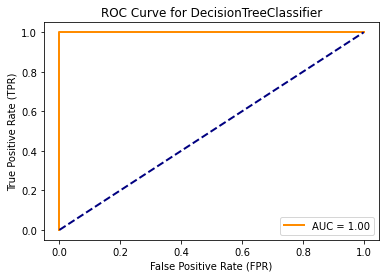

Classification report for DecisionTreeClassifier 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



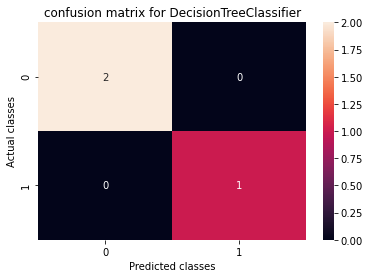

In [9]:
models_list = [LogisticRegression(), 
               RidgeClassifier(), 
               SVC(), 
               RandomForestClassifier(), 
               GradientBoostingClassifier(), 
               MLPClassifier(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier()]

for model in models_list:
    run_classifiers(model)